In [5]:
import scanpy as sc
import pandas as pd
import numpy as np


path='/Volumes/Seagate 8Tb/10X_KO_1/Mcidas/'
results_file = '/Volumes/Seagate 8Tb/10X_KO_1/Mcidas/Mcidas_v8_scanpy_rerun.h5ad'  # the file that will store the analysis results

sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx(path + 'filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

adata

/Users/lb/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 12333 × 31053
    var: 'gene_ids', 'feature_types'

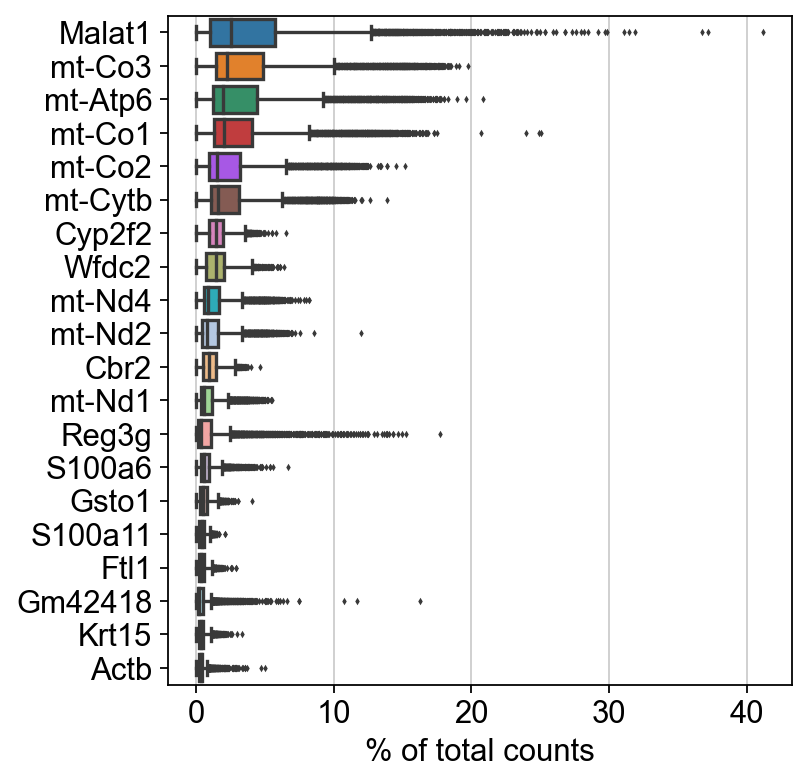

/Users/lb/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/Users/lb/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/lb/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/lb/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/lb/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/lb/anaconda3/lib/python3.7/s

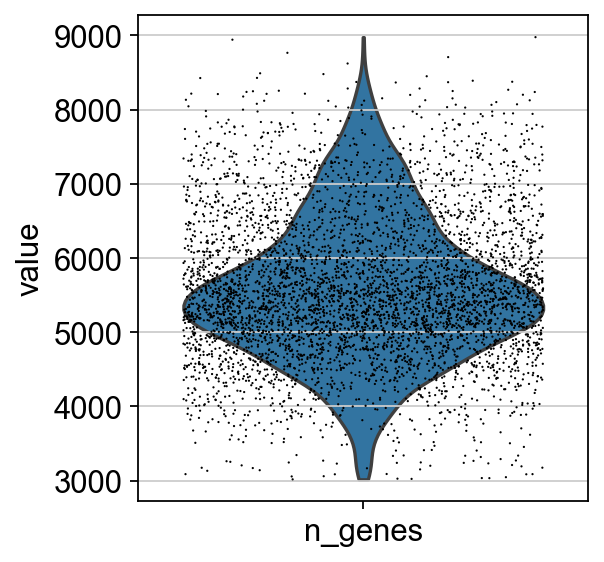

/Users/lb/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/lb/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lb/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


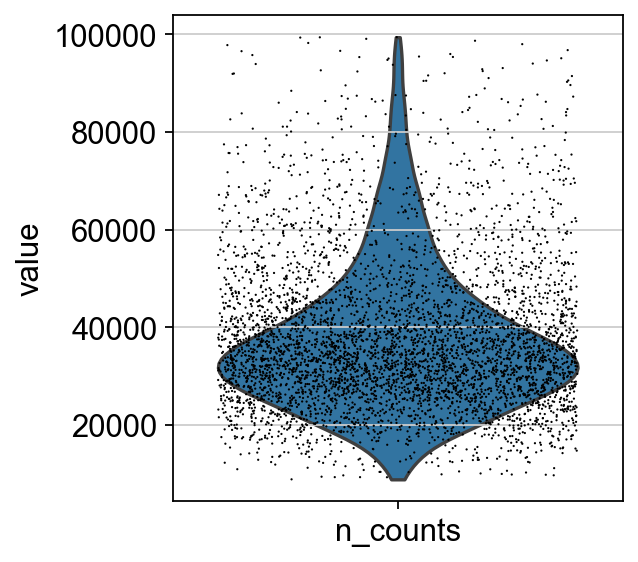

/Users/lb/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/lb/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lb/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


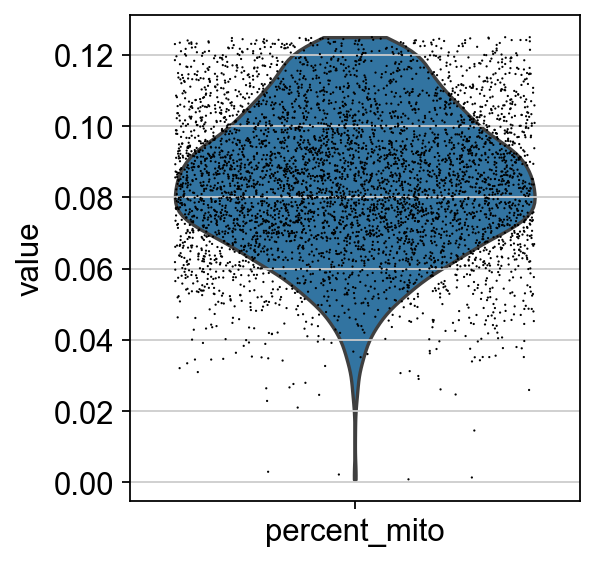

In [7]:
adata = adata[adata.obs['n_genes'] > 3000, :]
adata = adata[adata.obs['percent_mito'] < 0.125, :]
adata = adata[adata.obs['n_counts'] < 100000, :]
sc.pl.violin(adata, ['n_genes'],jitter=0.4)
sc.pl.violin(adata, ['n_counts'],jitter=0.4)
sc.pl.violin(adata, ['percent_mito'],jitter=0.4)

In [8]:
####### doublets ##########

import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
counts_matrix = adata.X
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))

Counts matrix shape: 4836 rows, 18444 columns


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.8%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 3.9%
Elapsed time: 9.3 seconds
Detected doublet rate = 7.8%
Estimated detectable doublet fraction = 48.1%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 16.3%


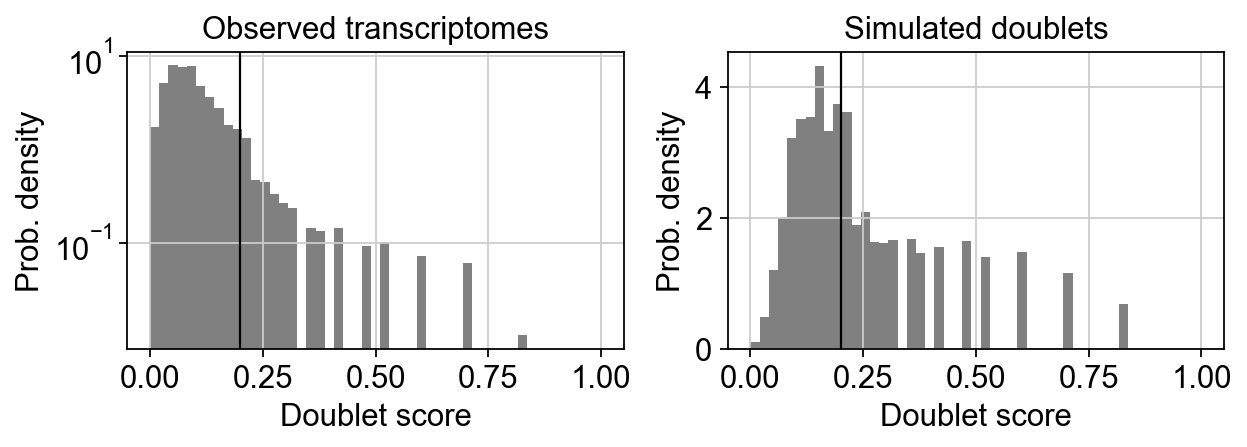

In [10]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=.08)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

predicted_doublets = scrub.call_doublets(threshold=0.2)

scrub.plot_histogram();

Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 29.2%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 8.7%


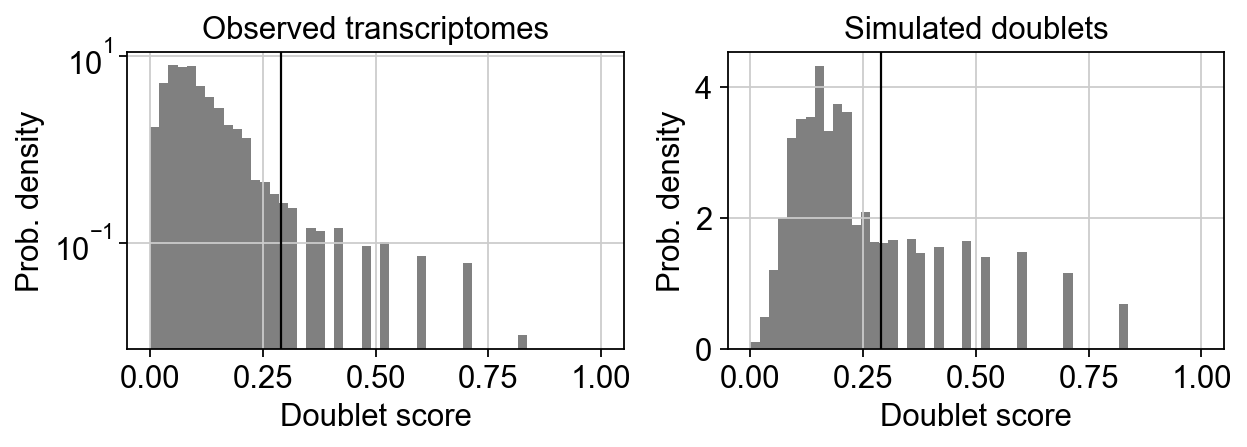

In [12]:
predicted_doublets = scrub.call_doublets(threshold=0.29)

scrub.plot_histogram();

In [13]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);
#plt.savefig('/Users/lb/Documents/Reiter_Seq/10X_070219/v13/WtAd3_scrublet_12perc_thresh28_umap.png')

Running UMAP...


/Users/lb/anaconda3/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/Users/lb/anaconda3/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.scatter(x[o], y[o], s=marker_size, edgecolors='', c=called_doubs[o], cmap=custom_cmap([[.7,.7,.7], [0,0,0]]))


ValueError: Expected 2-dimensional array, got 1

<Figure size 640x320 with 3 Axes>

In [14]:
cellbarc = adata.obs.index

df=pd.DataFrame({
        'cell_barcodes':cellbarc,
        'doublet_score':scrub.doublet_scores_obs_,
        'predicted_doublet':scrub.predicted_doublets_
        })
df.to_csv(path+'Mcidas_v8_scrublet_8perc_thresh0.29_output_table_rerun.csv',index=False)

In [15]:
cellbarc

Index(['AAACCCAGTCAAAGCG-1', 'AAACCCAGTCATCGGC-1', 'AAACCCAGTGAGTAGC-1',
       'AAACCCATCCATTTGT-1', 'AAACGAACACACTGGC-1', 'AAACGAAGTCATCACA-1',
       'AAACGCTAGGTTTACC-1', 'AAACGCTTCGTTAGTG-1', 'AAACGCTTCTTAGTTC-1',
       'AAAGAACAGGTTCAGG-1',
       ...
       'TTTGATCGTGTGGTCC-1', 'TTTGATCGTTGCTCGG-1', 'TTTGGAGCAAATGAAC-1',
       'TTTGGAGCAAGACGAC-1', 'TTTGGAGCAATTGCGT-1', 'TTTGGAGTCGACGCGT-1',
       'TTTGGTTGTAGCTCGC-1', 'TTTGTTGAGGCGAACT-1', 'TTTGTTGGTCGATGCC-1',
       'TTTGTTGTCGCTACAA-1'],
      dtype='object', length=4836)